In [248]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Visualization

In [249]:
import torch
import glob

import matplotlib.pyplot as plt
import viz
import random

### Load a pre-trained MAE model

In [250]:
model = viz.prepare_model(chkpt_dir="out_mae_vit_tiny_xformers_scaled_dot_product_MLP_i64_p8_b512_e200-norm-pix-loss",
                          arch="mae_vit_tiny")

# model = viz.prepare_model(chkpt_dir="out_mae_vit_small_scaled_dot_product_i128_p16_b512_e200", 
#                           chkpt_name="40", # Optional
#                           arch="mae_vit_small")

Loading checkpoint:  ../Model_Saving/out_mae_vit_tiny_xformers_scaled_dot_product_MLP_i64_p8_b512_e200-norm-pix-loss/checkpoint-199.pth
args: {'batch_size': 512, 'epochs': 200, 'accum_iter': 1, 'model_type': None, 'model': 'mae_vit_tiny', 'input_size': 64, 'patch_size': 8, 'attn_name': 'scaled_dot_product', 'ffn_name': 'MLP', 'use_xformers': True, 'mask_ratio': 0.75, 'spatial_mask': False, 'norm_pix_loss': True, 'weight_decay': 0.05, 'lr': 0.002, 'blr': 0.001, 'min_lr': 0.0, 'warmup_epochs': 40, 'train_path': '../fmow-rgb-preproc/train_64.csv', 'dataset_type': 'rgb', 'masked_bands': None, 'dropped_bands': None, 'grouped_bands': [], 'output_dir': '../Model_Saving/out_mae_vit_tiny_xformers_scaled_dot_product_MLP_i64_p8_b512_e200', 'log_dir': './logs', 'device': 'cuda', 'seed': 0, 'resume': '', 'wandb': 'satmae_debug', 'wandb_entity': 'utk-iccv23', 'start_epoch': 0, 'num_workers': 10, 'pin_mem': True, 'world_size': 1, 'local_rank': 0, 'dist_on_itp': False, 'dist_url': 'env://', 'distribut

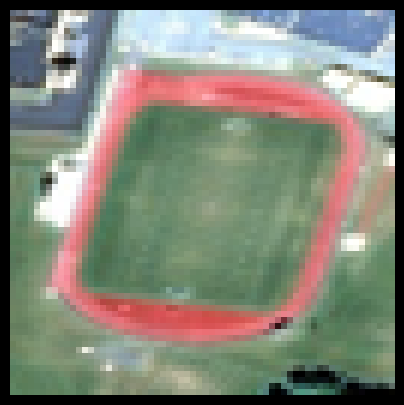

In [251]:
# load an image
# img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFQsDBSqgPKLHyunyQ0LJVDBXwzpnvWJqAOLPvVaUoA0xP-ZH4PPVCuyZtMllgEHSRTog&usqp=CAU'
# img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQSEHLflglbuqe5FfipsPHIQHOSmDX46YBMQIt2yiIZteSj6k_bnnVtAgNGrSWIYAovuzM&usqp=CAU'
# img_data = requests.get(img_url, stream=True).raw

img = viz.prepare_image('./images/0.jpg', model)
plt.rcParams["figure.figsize"] = [5, 5]
ax = plt.subplot(1, 1, 1)
viz.show_image(torch.tensor(img), ax=ax)

In [252]:
def show_comp(img, model, maskseed=None, figsize=15):
    # if img is string
    if isinstance(img, str):
        img = viz.prepare_image(img, model)
    x, im_masked, y, im_paste = viz.run_one_image(img, model, seed=maskseed)
    
    # make the plt figure larger
    plt.rcParams["figure.figsize"] = [figsize, figsize]
    
    imgs = [x[0], im_masked[0], y[0], im_paste[0]]
    titles = ["original", "masked", "reconstruction", "reconstruction + visible"]
    
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        viz.show_image(imgs[i], ax, titles[i])

    plt.show()

### Run MAE on the image

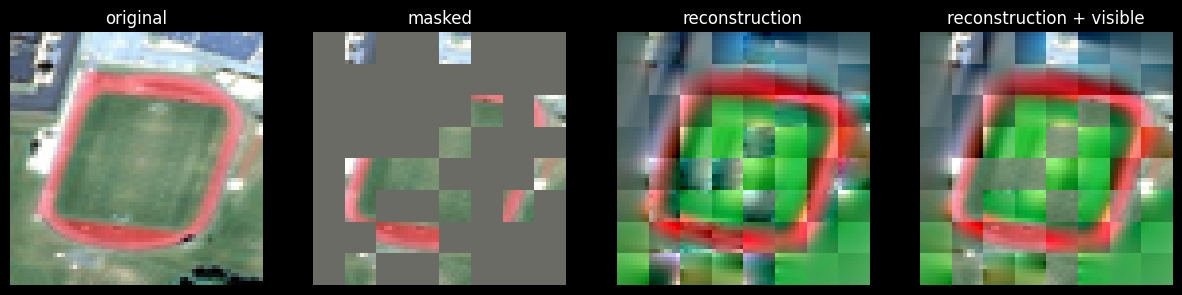

In [253]:
show_comp('./images/0.jpg', model, maskseed=1, figsize=15)
# run_one_image(img, model_mae, seed=2)

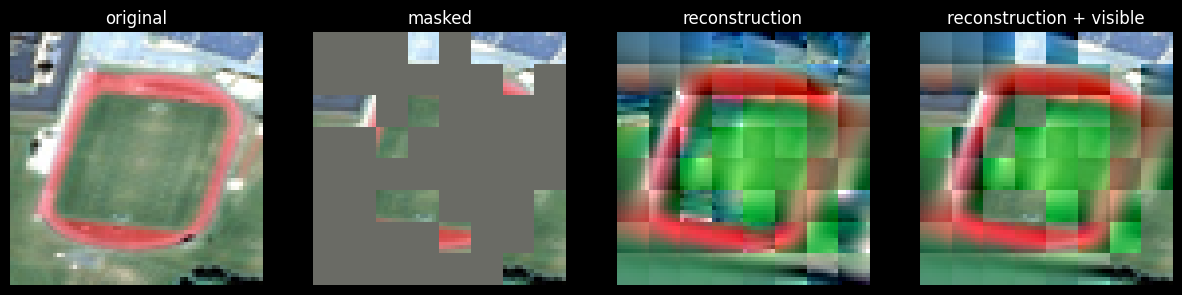

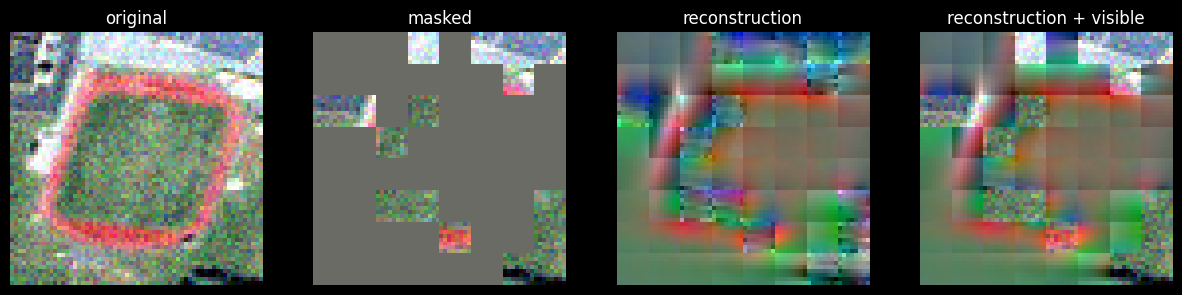

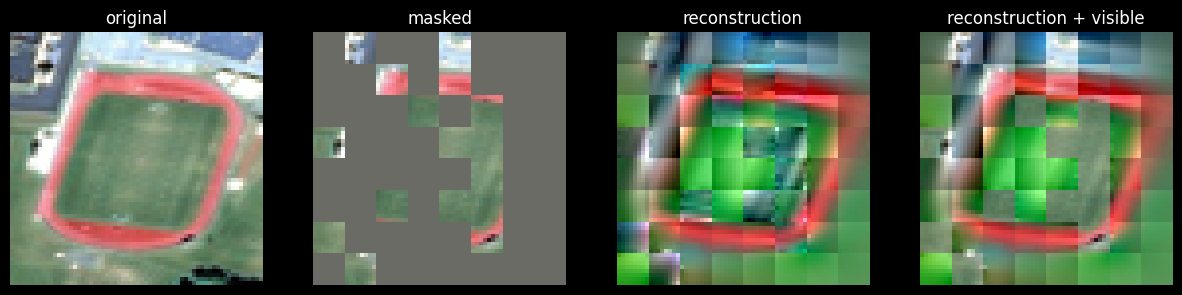

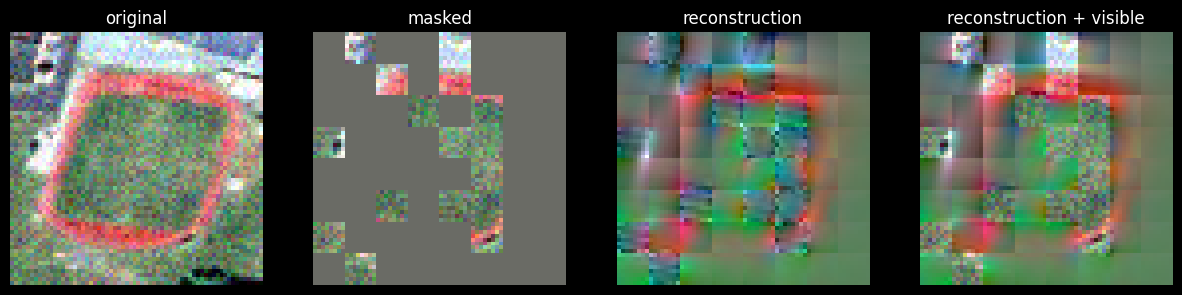

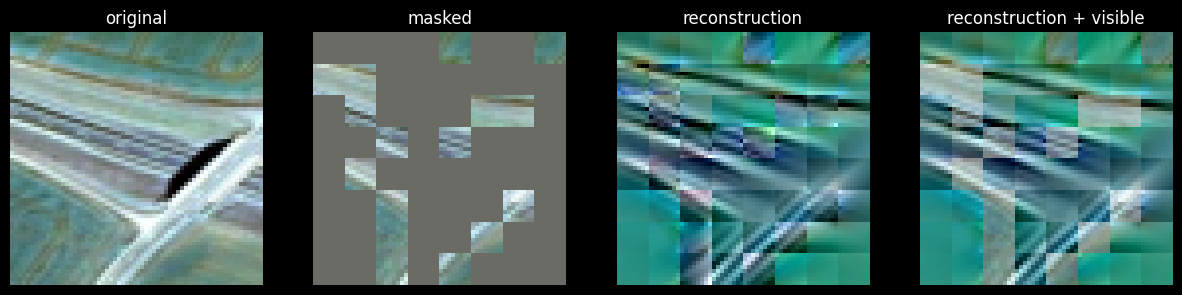

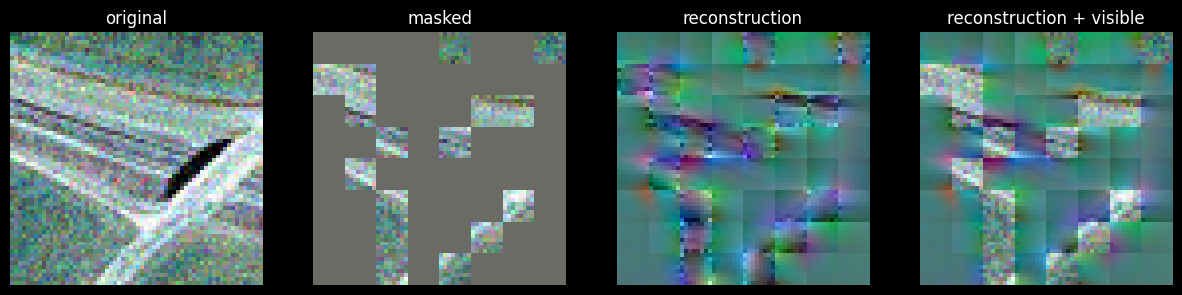

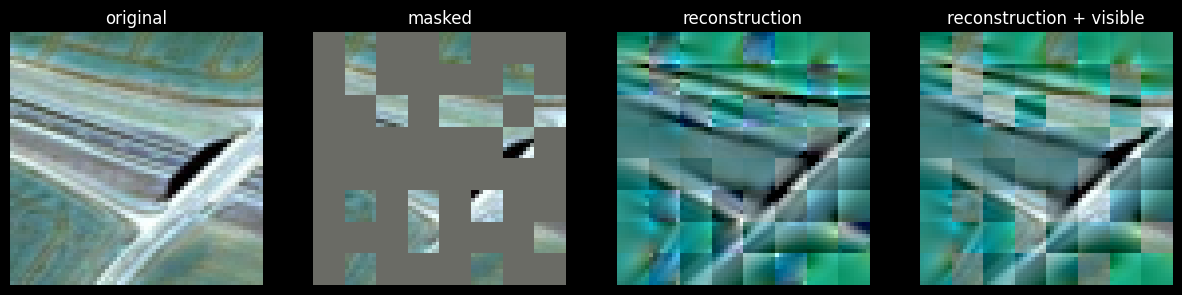

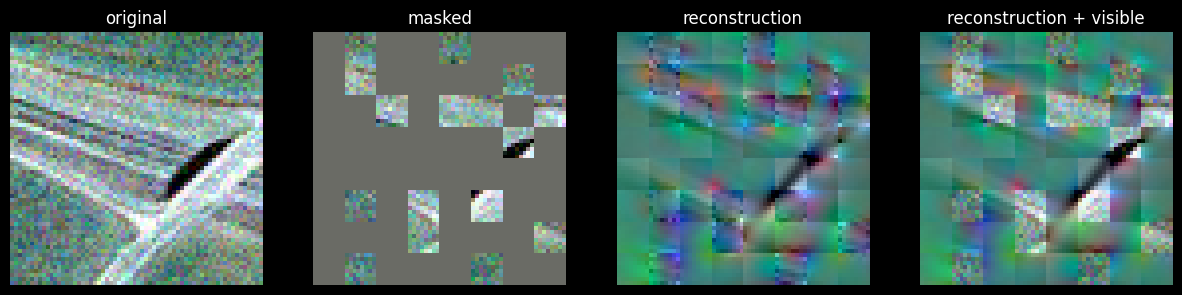

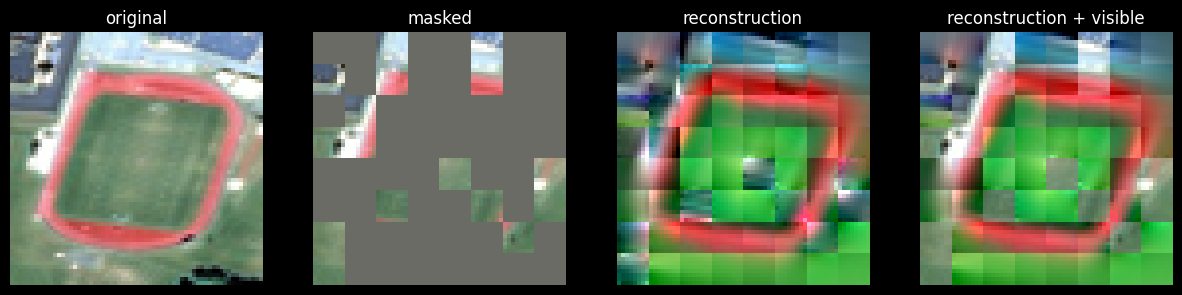

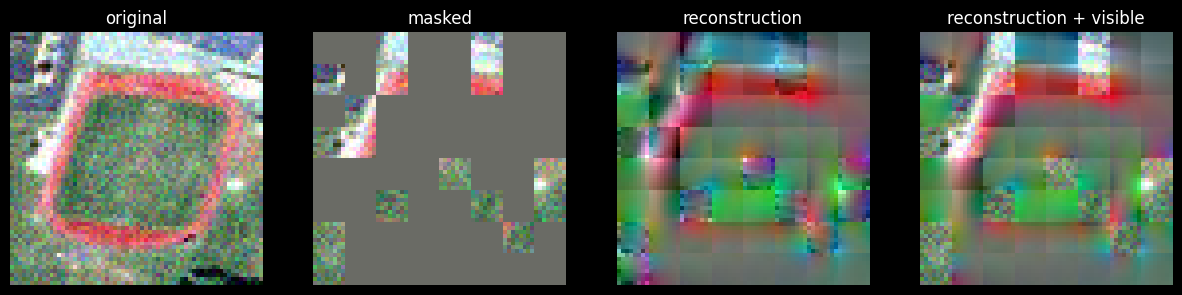

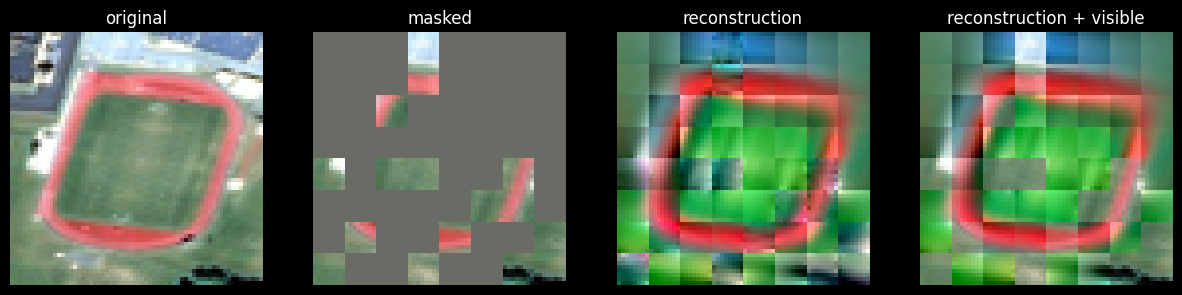

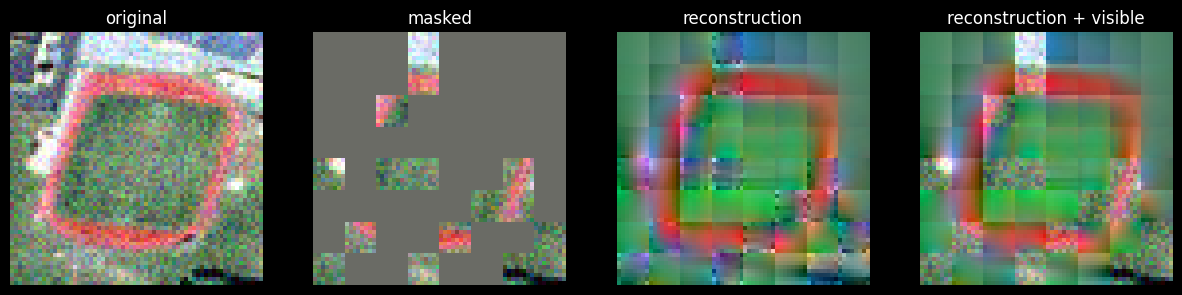

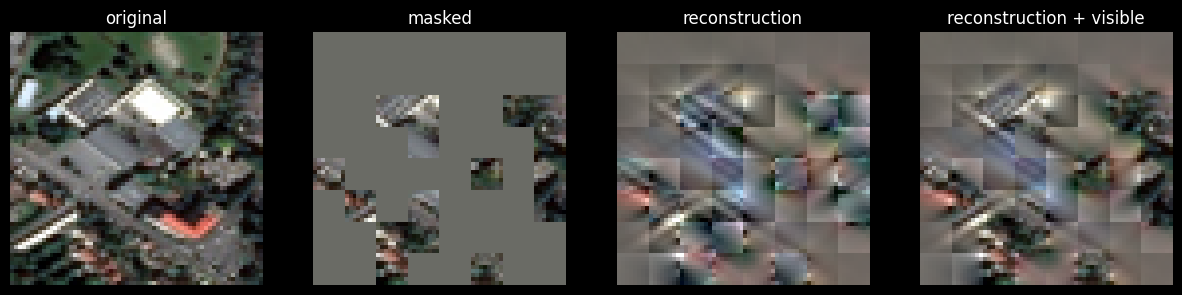

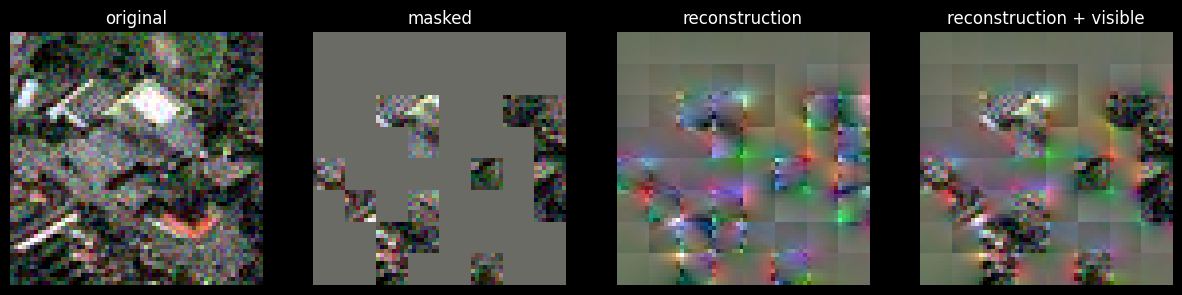

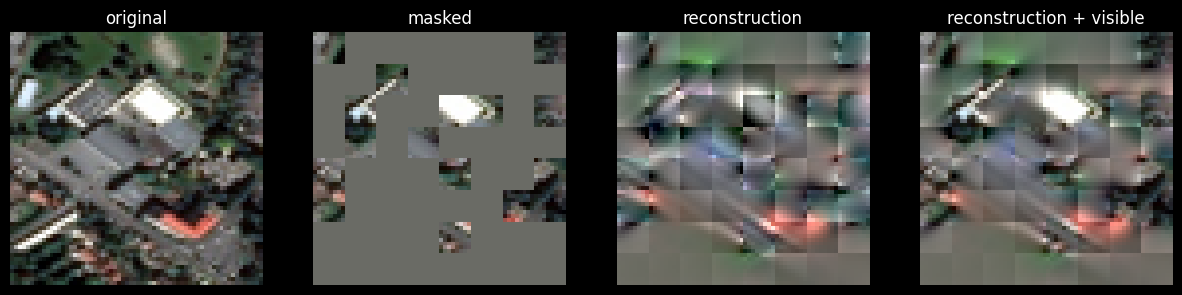

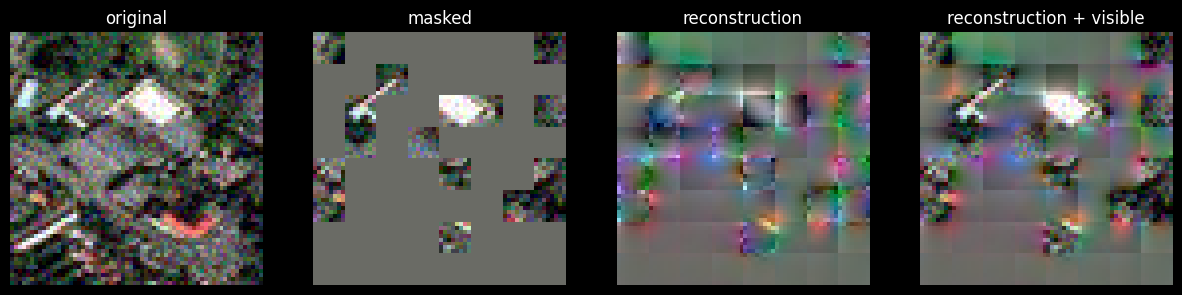

In [254]:
import numpy as np


# basedir = "../fmow-rgb-preproc/data_64/input/test_data/test/"
basedir = "./images/"
num_images = 4
num_each = 2
walkseed = 123
maskseed = None
use_noise = None
use_noise = ("speckle", 0.3)

# for img_path in glob.iglob(basedir + '**/*.jpg', recursive=True):
random.seed(walkseed)
for _ in range(num_images):
    img_path = random.choice(glob.glob(f'{basedir}**/*.jpg', recursive=True))
    for _ in range(num_each):
        mseed = random.randint(0, 1000) if maskseed is None and use_noise is not None else maskseed
        # img = viz.add_noise(img, noise_type="s&p", noise_param=0.05)
        show_comp(img_path, model, maskseed=mseed, figsize=15)
        if use_noise is not None:
            img = viz.prepare_image(img_path, model)
            img = viz.add_noise(img, noise_type=use_noise[0], noise_param=use_noise[1])
            show_comp(img, model, maskseed=mseed, figsize=15)